# MVP

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# AWS Libraries
import logging
import boto3
from botocore.exceptions import ClientError

# NLP Libraries
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Geo-mapping Libraries
import geopandas
import geopy
import folium 

# Helper Functions
import MVP_acquire_ds, MVP_explore

# Skill Libray
import library

import warnings
warnings.filterwarnings("ignore")

## Data Acquisition

### Download the JSON Files from AWS S3 Bucket

In [19]:
# Create the s3 resource object
s3 = boto3.resource('s3')

# Download the json files from AWS

s3.Bucket("dspreparedjobpostings").download_file("df_ds_tx_prepared_backup.json", 
                                                 "df_ds_tx_prepared_backup.json")

s3.Bucket("wdpreparedjobpostings").download_file("df_wd_tx_prepared_backup.json", 
                                                 "df_wd_tx_prepared_backup.json")

# Print the last modified datetime of the prepared file of data scientist positions in TX
print("Last modified datetime for data scientist positions in TX: ", 
      s3.Object('dspreparedjobpostings', 'df_ds_tx_prepared_backup.json').last_modified)

# Print the last modified datetime of the prepared file of web developer positions in TX
print("Last modified datetime for web developer positions in TX: ", 
      s3.Object('wdpreparedjobpostings', 'df_wd_tx_prepared_backup.json').last_modified)

Last modified datetime for data scientist positions in TX:  2021-03-17 14:18:01+00:00
Last modified datetime for web developer positions in TX:  2021-03-17 14:21:16+00:00


## Data Preparation

### Load JSON Files into Dataframe

In [2]:
# Read the json file into pandas dataframe

df_ds = pd.read_json('df_ds_tx_prepared_backup.json')
df_wd = pd.read_json('df_wd_tx_prepared_backup.json')

# Print the number of job postings in each dataframe

print("Number of job postings for data scientists in TX: ", df_ds.shape[0])
print("Number of job postings for web developers in TX: ", df_wd.shape[0])

Number of job postings for data scientists in TX:  2979
Number of job postings for web developers in TX:  5928


In [3]:
# Print the concise summary of the job postings for data scientists
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2979 entries, 0 to 2978
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2979 non-null   datetime64[ns]
 1   title            2979 non-null   object        
 2   company          2979 non-null   object        
 3   company_rating   2979 non-null   float64       
 4   job_link         2979 non-null   object        
 5   job_description  2979 non-null   object        
 6   city             2979 non-null   object        
 7   state            2979 non-null   object        
 8   zipcode          2979 non-null   int64         
 9   clean            2979 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 232.9+ KB


In [4]:
# Print the most recent 5 job postings for data scientists
df_ds.head()

,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
0,2021-03-17,Sr. Data Scientist for Fin-Tech,SparkCognition,4.40,https://www.indeed.com/rc/clk?jk=5a7486384db13...,SparkCognition catalyzes sustainable growth fo...,Austin,TX,78759,sparkcognition catalyzes sustainable growth cl...
1,2021-03-17,Director of Data Science,Big Fish Games,3.60,https://www.indeed.com/rc/clk?jk=410144f481187...,Job Posting Title\nDirector of Data Science\nS...,Austin,TX,0,job posting title director data science summar...
2,2021-03-17,Senior-Data Scientist,AT&T,3.70,https://www.indeed.com/rc/clk?jk=c9f78b7db81cf...,The Data Science team is responsible for drivi...,Plano,TX,0,data science team responsible driving algorith...
3,2021-03-17,Data Engineer,LOCKHEED MARTIN CORPORATION,4.00,https://www.indeed.com/rc/clk?jk=6ff9f3c6c74ef...,The Lockheed Martin Artificial Intelligence Ce...,Fort Worth,TX,76107,lockheed martin artificial intelligence center...
4,2021-03-17,Machine Learning Research Engineer,Hired Recruiters,3.77,https://www.indeed.com/rc/clk?jk=7abc5c78c9fd9...,About the Role\nVideo.io is looking for passio...,Austin,TX,0,role videoio looking passionate software engin...


In [5]:
# Print the concise summary of the job postings for web developers
df_wd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5928 entries, 0 to 5927
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             5928 non-null   datetime64[ns]
 1   title            5928 non-null   object        
 2   company          5928 non-null   object        
 3   company_rating   5928 non-null   float64       
 4   job_link         5928 non-null   object        
 5   job_description  5928 non-null   object        
 6   city             5928 non-null   object        
 7   state            5928 non-null   object        
 8   zipcode          5928 non-null   int64         
 9   clean            5928 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 463.2+ KB


In [6]:
# Print the most recent 5 job postings for web developers
df_wd.head()

,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
0,2021-03-17,Web Developer,CyberCoders,3.2,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Web Developer\nJob Title: Web Developer\nLocat...,Arlington,TX,76015,web developer job title web developer location...
1,2021-03-17,.Net Developer,Cognizant Technology Solutions,3.9,https://www.indeed.com/rc/clk?jk=ecaf62a0674fd...,Roles & responsibilities:\nParticipate in requ...,Richardson,TX,75080,role responsibility participate requirement an...
2,2021-03-17,Software Engineer,Pizza Hut,3.6,https://www.indeed.com/rc/clk?jk=ccdd16eb0f32b...,Pizza Hut is looking for a self-motivated soft...,Plano,TX,0,pizza hut looking selfmotivated software engin...
3,2021-03-17,Front End Developer (Entry Level),Revature,3.4,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Revature is the fastest growing employer of em...,Midland,TX,0,revature fastest growing employer emerging tec...
4,2021-03-17,"Junior Software Engineer, Front End",Knock,3.7,https://www.indeed.com/rc/clk?jk=f37c931b23d1a...,Knock is on a mission to empower people to mov...,Austin,TX,0,knock mission empower people move freely knock...


### Consolidation

In [7]:
# Create a job code column: set value 0 for data scientis and 1 for web developers

df_ds = df_ds.assign(job_code = 0)
df_wd = df_wd.assign(job_code = 1)

# Concat the two dataframes
df = pd.concat([df_ds, df_wd])

# Inspect the new dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8907 entries, 0 to 5927
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             8907 non-null   datetime64[ns]
 1   title            8907 non-null   object        
 2   company          8907 non-null   object        
 3   company_rating   8907 non-null   float64       
 4   job_link         8907 non-null   object        
 5   job_description  8907 non-null   object        
 6   city             8907 non-null   object        
 7   state            8907 non-null   object        
 8   zipcode          8907 non-null   int64         
 9   clean            8907 non-null   object        
 10  job_code         8907 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 835.0+ KB


In [8]:
# Set the date as the index and sort in a descending order
df = df.set_index('date').sort_index(ascending=False)

# Rename the columns to be easily understood
df = df.rename(columns={'title': 'job_title', 'clean': 'cleaned_job_description'})

# Inspect the first 5 rows
df.head()

,job_title,company,company_rating,job_link,job_description,city,state,zipcode,cleaned_job_description,job_code
date,,,,,,,,,,
2021-03-17,Sr. Data Scientist for Fin-Tech,SparkCognition,4.40,https://www.indeed.com/rc/clk?jk=5a7486384db13...,SparkCognition catalyzes sustainable growth fo...,Austin,TX,78759,sparkcognition catalyzes sustainable growth cl...,0
2021-03-17,"Junior Software Engineer, Front End (Remote)",Knock,3.70,https://www.indeed.com/rc/clk?jk=af486a738ac19...,Knock is on a mission to empower people to mov...,Austin,TX,0,knock mission empower people move freely knock...,1
2021-03-17,Net Developer,National Partners in Healthcare,3.71,https://www.indeed.com/company/National-Partne...,Work with business leaders and subject matter ...,Richardson,TX,75082,work business leader subject matter expert get...,1
2021-03-17,Java/J2EE Developer,Advithri Technologies Inc,3.71,https://www.indeed.com/rc/clk?cmp=Advithri-Tec...,We are looking for a Java Developer with exper...,Plano,TX,75023,looking java developer experience building hig...,1
2021-03-17,Software Developer I,Operation Homefront,4.10,https://www.indeed.com/rc/clk?jk=e674162adfd15...,"Founded in 2002, Operation Homefront is a nati...",San Antonio,TX,78232,founded 2002 operation homefront national nonp...,1


**Takeaways**
1. Some zipcodes are 0, which indicates they are not provided by the employers.
2. Some values in `city` column are 'Remote', which indicates the jobs do not require a specific location. 
3. So far, all the jobs are located in TX beside the remote ones and the `state` column is kept for geospacial analysis. 

### Handle Missing Values

In [9]:
# Count the missing values in each column
df.isnull().sum(axis=0)

job_title                  0
company                    0
company_rating             0
job_link                   0
job_description            0
city                       0
state                      0
zipcode                    0
cleaned_job_description    0
job_code                   0
dtype: int64

**Takeaways**
1. No null values has been found in the job postings. 

#### Zipcode

In [10]:
# How many zipcodes are not availabe?
df.zipcode.value_counts(normalize=True).head(1)

0    0.518693
Name: zipcode, dtype: float64

**Takeaways**
1. 52% of the zipcodes are not provided. 
2. How to handle the zipcodes with value 0?
    - option 1: drop the entire column because the ratio of the missing values is more than 50%.
    - option 2: drop the rows but we will lose half of the data. 
    - option 3: impute by the company and its location and it may need outside resource.
3. We choose to drop the `zipcode` column because our dashboard doesn't need the zipcode level of details.

In [11]:
# Drop the zipcode column

df = df.drop(columns='zipcode')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8907 entries, 2021-03-17 to 2020-12-22
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   job_title                8907 non-null   object 
 1   company                  8907 non-null   object 
 2   company_rating           8907 non-null   float64
 3   job_link                 8907 non-null   object 
 4   job_description          8907 non-null   object 
 5   city                     8907 non-null   object 
 6   state                    8907 non-null   object 
 7   cleaned_job_description  8907 non-null   object 
 8   job_code                 8907 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 695.9+ KB


#### City

In [12]:
# How many jobs are categorized as 'Remote'?

num_remote = (df.city == 'Remote').sum()
num_jobs = df.shape[0]
print(f"{num_remote} jobs are remote, which is {round(num_remote*100/num_jobs, 1)}% of all the job postings.")

548 jobs are remote, which is 6.2% of all the job postings.


**Takeaways**
1. We will keep the remote jobs and compare their requirements with that of the unremote jobs.

#### Job Description

In [13]:
# How many job descriptions are missing?

num_missing = (df.job_description == 'error').sum()

print(f"{num_missing} jobs show 'error' in their descriptions, \
which is {round(num_missing*100/num_jobs, 1)}% of all the job postings.")

361 jobs show 'error' in their descriptions, which is 4.1% of all the job postings.


**Takeaways**
1. The value 'error' shows in the `job_descripion` column if the response is Nonetype when making a request to a detailed job posting page. 
2. Because only a small portion (less than 5%) are without the job description, we decide to keep those postings. 

### Clean Job Titles

In [14]:
# Count the frequency of a job title and list the top 20
df.job_title.value_counts().head(20)

Data Scientist                  312
Web Developer                   145
Software Engineer               129
Senior Data Scientist           119
Software Developer               94
Senior Software Engineer         92
Full Stack Developer             88
Java Developer                   79
Machine Learning Engineer        71
Senior Data Analyst              67
Front End Developer              66
UI Developer                     53
Sr. Data Scientist               49
PHP Developer                    47
Principal Data Scientist         46
Full Stack Software Engineer     44
Senior Software Developer        44
Web Designer                     42
Web Designer/Developer           41
.Net Developer                   41
Name: job_title, dtype: int64

**Takeaways**
1. Some senior positions use the abbreviation of senior - 'Sr.' in the job titles. We decide to use the full spelling so the 'Sr.' need to be replaced with 'Senior'.

In [15]:
# Replace 'Sr.' with 'Senior'
df.job_title = df.job_title.str.replace('Sr.', 'Senior')

# Re-Count the frequency of a job title and list the top 20
df.job_title.value_counts().head(20) 

Data Scientist                  312
Senior Data Scientist           168
Web Developer                   145
Software Engineer               129
Senior Software Engineer        113
Senior Data Analyst             105
Software Developer               94
Full Stack Developer             88
Java Developer                   79
Machine Learning Engineer        71
Front End Developer              66
UI Developer                     53
PHP Developer                    47
Principal Data Scientist         46
Senior Software Developer        45
Full Stack Software Engineer     44
Web Designer                     42
.Net Developer                   41
Web Designer/Developer           41
Front End Engineer               39
Name: job_title, dtype: int64

### Clean Company Names

In [16]:
# We noticed Amazon has three names in its job postings

amazon = df.company.str.contains("Amazon")
df[amazon].company.value_counts()

Amazon Web Services, Inc.       55
Amazon.com Services LLC         30
Amazon Dev Center U.S., Inc.     1
Name: company, dtype: int64

In [17]:
# We noticed Dell has two names in its job postings

dell = df.company.str.contains("Dell")
df[dell].company.value_counts()

Dell Technologies    85
Dell                  9
Name: company, dtype: int64

**Takeaways**
1. Although the job postings from Amazon are listed under three different company names, all of them have the same company page on Indeed - Amazon.com. We decide to give them the same company name "Amazon.com"
2. Likewise, we decide to give the job postings from Dell the same company name "Dell Technologies".

In [18]:
# Define a function to clean the company names

def clean_company_names(i):
    if "Amazon" in i:
        i = "Amazon.com"
    elif i == "Dell":
        i = "Dell Technologies"
    return i

In [19]:
# Clean the company names
df.company = df.company.apply(clean_company_names)

In [20]:
# Sanity check
df[amazon].company.value_counts()

Amazon.com    86
Name: company, dtype: int64

In [21]:
# Sanity check
df[dell].company.value_counts()

Dell Technologies    94
Name: company, dtype: int64

### Clean City Column
**Notes**: We noticed that several values in the `city` column are not cities and they are listed below
- Military posts: Fort Same Houston, Lackland AFB in San Antonio
- Metroplex: Dallas-Fort Worth
- Area: Las Colinas: an affluent and upscale area in Irving, TX. 
- Community: New York: an unincorporated community in Henderson County, TX. 

#### Military Posts

In [28]:
# How many jobs are posted from military posts?

military_post = (df.city == "Fort Sam Houston") | (df.city == "Lackland AFB")
military_post.sum()

5

**Takeaways**: Only 5 jobs postings are from military posts in San Antonio. We decide to reassign them to San Antonio. 

In [40]:
# Replace military posts with the city where they are located
df.city = df.city.apply(lambda i: "San Antonio" if (i == "Fort Sam Houston") | (i == "Lackland AFB") else i)

# Sanity check
military_post = (df.city == "Fort Sam Houston") | (df.city == "Lackland AFB")
military_post.sum()

0

#### Metroplex

In [41]:
# How many jobs are posted from Dallas-Fort Forth?

metroplex = (df.city == "Dallas-Fort Worth")
metroplex.sum()

63

In [48]:
# How many companies posted jobsing using Dallas-Fort Worth as location?
df[metroplex].company.nunique()

23

**Takeaways** There are 8 principal cities in this metroplex and they are Dallas, Fort Worth, Arlington, Plano, Irving, Denton, Richardson, and Grapevine. We decide to reassign all of them to city Dallas. 

In [50]:
# Rename as Dallas
df.city = df.city.str.replace("Dallas-Fort Worth", "Dallas")

# Sanity check
metroplex = (df.city == "Dallas-Fort Worth")
metroplex.sum()

0

### Handle the Reposted Jobs
**Notes**: The first step in the data cleaning in the back end has already removed the duplicated job postings based on the job title, location, company, job link and job description. The duplicates in section indicates the jobs are either reposted or the extra is needed for the same position. So far, we couldn't tell the difference between the two. We assume the majority of them are reposted. 

In [22]:
# How many jobs are reposted in the dataframe?

# Define the columns for identifying duplicates
cols = ['job_title', 'company', 'company_rating', 'job_link', 'city', 'job_code']

# Compute the number of duplicates 
num_duplicates = df.duplicated(subset=cols).sum()

print(f"{num_duplicates} jobs are reposted, \
which is {round(num_duplicates*100/num_jobs, 1)}% of all the job postings.")

2095 jobs are reposted, which is 23.5% of all the job postings.


**Takeaways**
1. Nearly one quarter of new posted jobs are acturally reposted. 
2. We decide to keep the reposts and create a new column `repost` to label each job postings so as to distinguish them. 

In [23]:
# Create a new column name `repost`

reposted = df.duplicated(subset=cols, keep="last") # Make duplicates as True except for the last occurrence
df = df.assign(repost=reposted)

# Sanity check: `repost` column has been created successfully
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8907 entries, 2021-03-17 to 2020-12-22
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   job_title                8907 non-null   object 
 1   company                  8907 non-null   object 
 2   company_rating           8907 non-null   float64
 3   job_link                 8907 non-null   object 
 4   job_description          8907 non-null   object 
 5   city                     8907 non-null   object 
 6   state                    8907 non-null   object 
 7   cleaned_job_description  8907 non-null   object 
 8   job_code                 8907 non-null   int64  
 9   repost                   8907 non-null   bool   
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 704.6+ KB


## Data Exploration

### Where Are the Jobs - Geospatial Analysis

#### Data Scientist Position

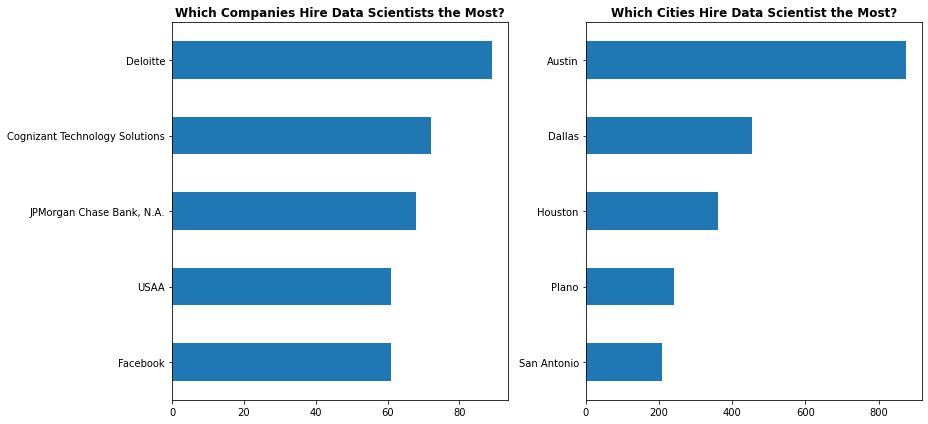

In [8]:
# Barplot the top 5 companies and top 5 cities by the number of the job posts

plt.figure(figsize=(13,6))

plt.subplot(121)
top_companies = df_ds.company.value_counts().head(5)
top_companies.sort_values().plot(kind='barh')
plt.title("Which Companies Hire Data Scientists the Most?", fontweight='bold')

plt.subplot(122)
top_cities = df_ds.city.value_counts().head(5)
top_cities.sort_values().plot(kind='barh')
plt.title("Which Cities Hire Data Scientist the Most?", fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# How does the number of job postings change over time?
df_ds.resample('W').title.count()

date
2020-12-27    392
2021-01-03    136
2021-01-10    212
2021-01-17    187
2021-01-24    352
2021-01-31    295
2021-02-07    269
2021-02-14    305
2021-02-21    185
2021-02-28    235
2021-03-07    232
2021-03-14     97
Freq: W-SUN, Name: title, dtype: int64

In [10]:
# Which company has the best avereage rating? 
df_ds.groupby('company').company_rating.mean().sort_values(ascending=False).head()

company
Digital Pharmacist    5.0
Rekruiters            5.0
Onit                  4.7
Levelset              4.7
Harnham               4.6
Name: company_rating, dtype: float64

In [11]:
df_ds.title.value_counts().head()

Data Scientist               306
Senior Data Scientist        115
Senior Data Analyst           66
Machine Learning Engineer     60
Sr. Data Scientist            48
Name: title, dtype: int64

#### Web Developer Position

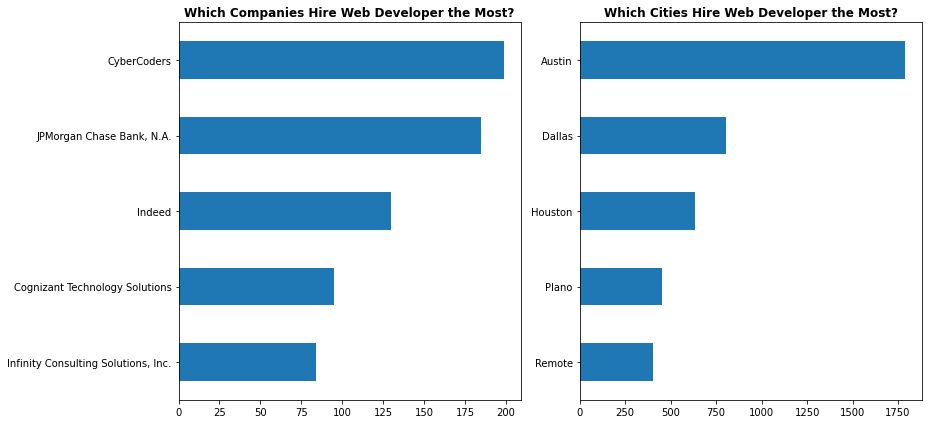

In [12]:
# Barplot the top 5 companies and top 5 cities by the number of the job posts

plt.figure(figsize=(13,6))

plt.subplot(121)
top_companies = df_wd.company.value_counts().head(5)
top_companies.sort_values().plot(kind='barh')
plt.title("Which Companies Hire Web Developer the Most?", fontweight='bold')

plt.subplot(122)
top_cities = df_wd.city.value_counts().head(5)
top_cities.sort_values().plot(kind='barh')
plt.title("Which Cities Hire Web Developer the Most?", fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
# How does the number of job postings change over time?
df_wd.resample('W').title.count()

date
2021-01-10      62
2021-01-17     346
2021-01-24     793
2021-01-31    1054
2021-02-07     825
2021-02-14     786
2021-02-21     452
2021-02-28     520
2021-03-07     542
2021-03-14     347
Freq: W-SUN, Name: title, dtype: int64

In [14]:
# Which company has the best avereage rating? 
df_wd.groupby('company').company_rating.mean().sort_values(ascending=False).head()

company
Givelify                        5.0
ALAANT                          5.0
MPIRE Technology Group, Inc.    5.0
RightNow Ministries             5.0
Royal & Ross                    5.0
Name: company_rating, dtype: float64

In [15]:
df_wd.title.value_counts().head()

Web Developer               138
Software Engineer           127
Software Developer           92
Senior Software Engineer     88
Full Stack Developer         86
Name: title, dtype: int64

### Top k Needed Skills

#### Data Scientist Position
- Tech Skills
- Soft Skills
- General Skills (Combination of Tech+Soft)

In [16]:
# Import library
ds_tech_library = library.library_ds_tech

# Print the number of skills in the library
print("Number of data science skills in tech skill library: ", len(ds_tech_library))

# Print the top 5 needed tech skills

ds_top_tech = MVP_explore.top_skills(df_ds, 5, ds_tech_library, 'tech')
ds_top_tech

Number of data science skills in tech skill library:  71
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_tech_skills,frequency
0,machine learning,4368.0
1,python,2361.0
2,sql,1762.0
3,aws,1417.0
4,r,1297.0


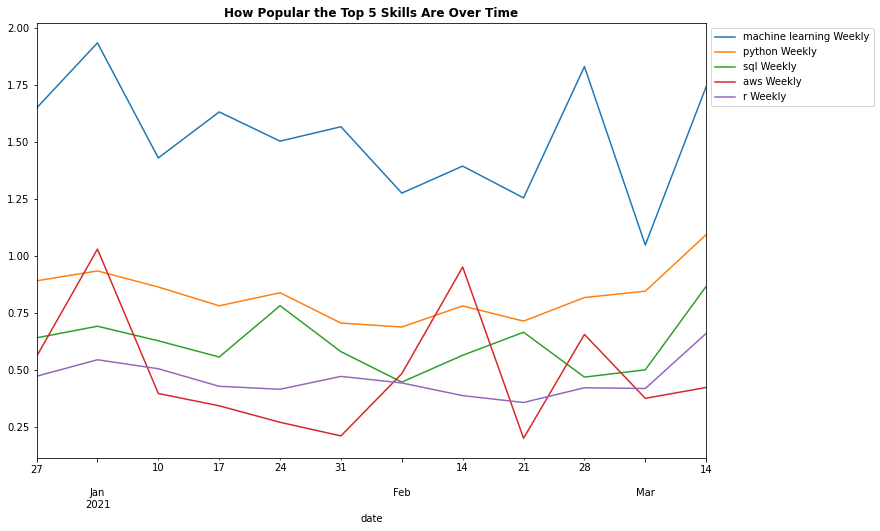

In [17]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_tech)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_tech)

In [18]:
# Import library
ds_soft_library = library.library_ds_soft

# Print the number of skills in the library
print("Number of data science skills in soft skill library: ", len(ds_soft_library))

# Print the top 5 needed soft skills

ds_top_soft = MVP_explore.top_skills(df_ds, 5, ds_soft_library, 'soft')
ds_top_soft

Number of data science skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_soft_skills,frequency
0,communication,1972.0
1,leadership,1312.0
2,collaboration,572.0
3,problem solving,426.0
4,written communication,330.0


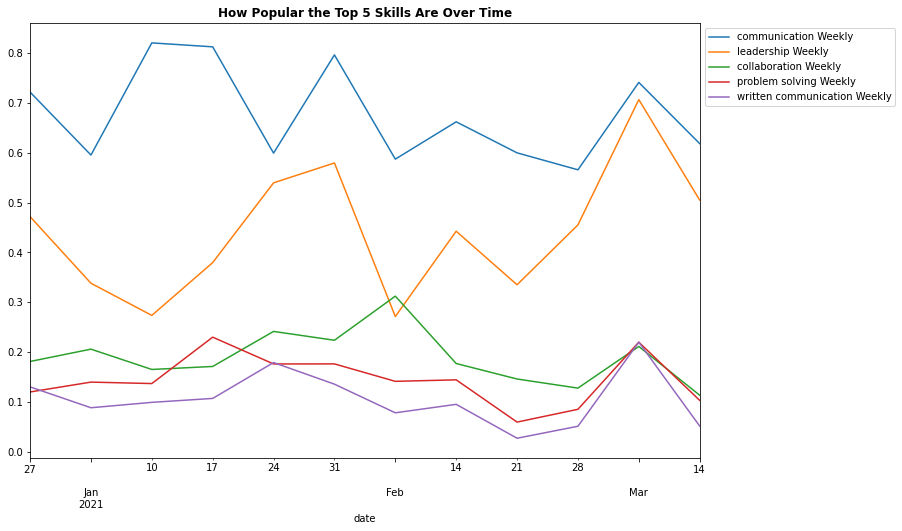

In [19]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_soft)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_soft)

In [20]:
# Import library
ds_general_library = library.library_ds_general

# Print the number of skills in the library
print("Number of data science skills in general skills library: ", len(ds_general_library))

# Print the top 5 needed general skills

ds_top_general = MVP_explore.top_skills(df_ds, 5, ds_general_library, 'general')
ds_top_general

Number of data science skills in general skills library:  90
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_general_skills,frequency
0,machine learning,4368.0
1,python,2361.0
2,communication,1972.0
3,sql,1762.0
4,aws,1417.0


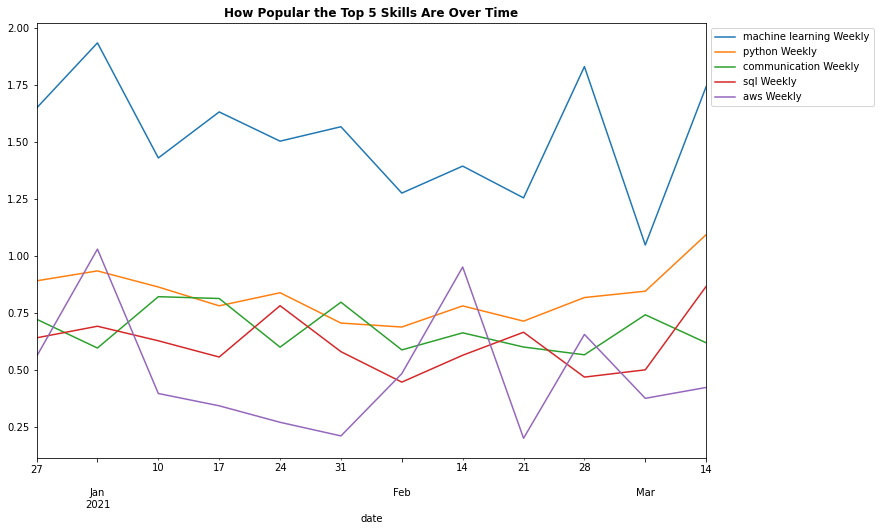

In [21]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_general)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_general)

#### Web Developer Position
- Tech skills
- Soft skills
- General Skills (Combination of Tech+Soft)

In [22]:
# Import library
wd_tech_library = library.library_wd_tech

# Print the number of skills in the library
print("Number of web dev skills in tech skill library: ", len(wd_tech_library))

# Print the top 5 needed tech skills

wd_top_tech = MVP_explore.top_skills(df_wd, 5, wd_tech_library, 'tech')
wd_top_tech

Number of web dev skills in tech skill library:  67
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_tech_skills,frequency
0,javascript,4511.0
1,java,3037.0
2,sql,2741.0
3,react,2438.0
4,c,2263.0


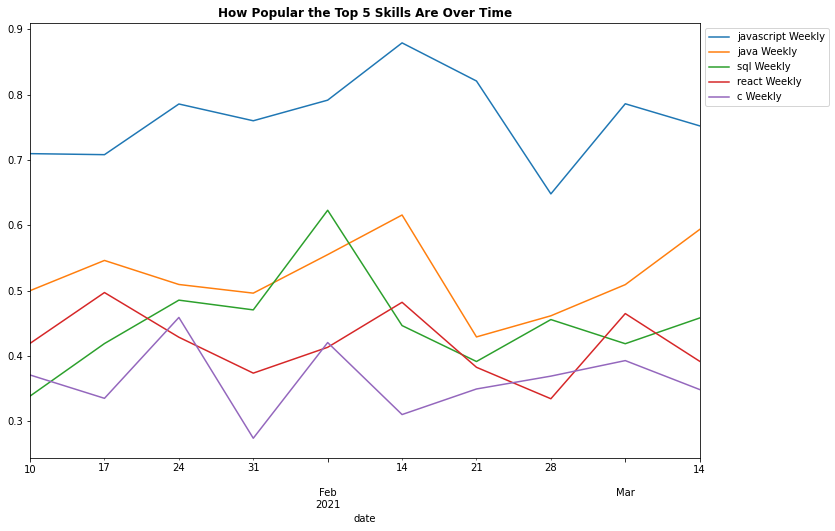

In [23]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_tech)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_tech)

In [24]:
# Import library
wd_soft_library = library.library_wd_soft

# Print the number of skills in the library
print("Number of web dev skills in soft skill library: ", len(wd_soft_library))

# Print the top 5 needed soft skills

wd_top_soft = MVP_explore.top_skills(df_wd, 5, wd_soft_library, 'soft')
wd_top_soft

Number of web dev skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_soft_skills,frequency
0,communication,3365.0
1,leadership,1306.0
2,collaboration,896.0
3,problem solving,711.0
4,written communication,504.0


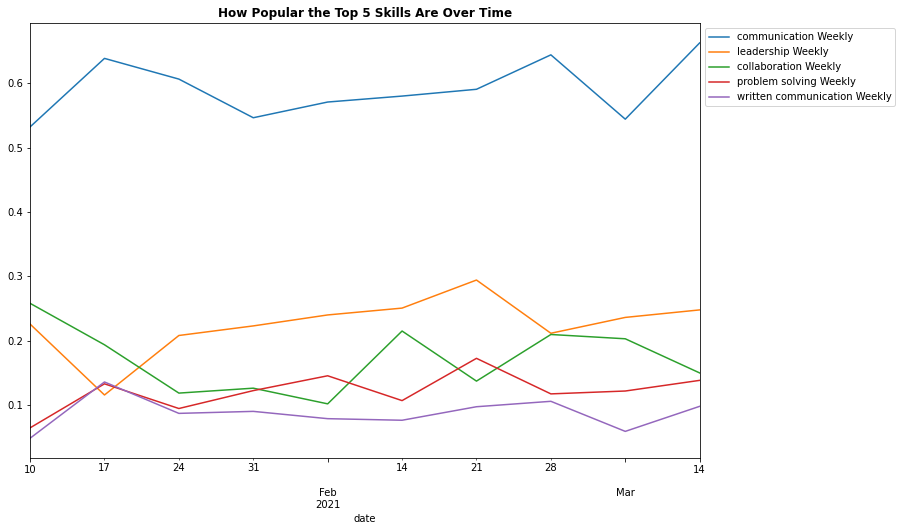

In [25]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_soft)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_soft)

In [26]:
# Import library
wd_general_library = library.library_wd_general

# Print the number of skills in the library
print("Number of web dev skills in general skill library: ", len(wd_general_library))

# Print the top 5 needed general skills

wd_top_general = MVP_explore.top_skills(df_wd, 5, wd_general_library, 'general')
wd_top_general

Number of web dev skills in general skill library:  86
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_general_skills,frequency
0,javascript,4511.0
1,communication,3365.0
2,java,3037.0
3,sql,2741.0
4,react,2438.0


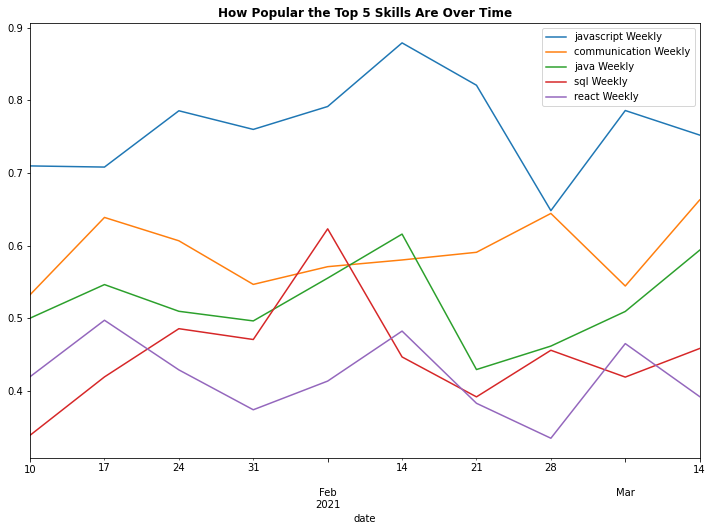

In [27]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_general)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_general)